Package Imports

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score

import matplotlib.pyplot as plt

Global Declarations

In [30]:
DATA = '../data/data.csv'
NEIGHBOURHOOD = []
ROOM_TYPE = []

Data Preprocessing

In [31]:
#read data from csv file
def read_data(file_name):
    data = pd.read_csv(file_name)
    return data 

In [32]:
def df_cleanup():
    
    df = pd.DataFrame(read_data(DATA))

    numerical_columns = df.select_dtypes(include='number')
    correlation_matrix = numerical_columns.corr()
    # Heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix of Numerical Features')
    plt.xticks(rotation = 25)
    plt.show()

    df = df.drop(df[df.availability_365 < 1].index)
    
    df = df.drop('license', axis=1)
    df = df.drop('last_review', axis=1)
    df = df.drop('reviews_per_month', axis=1)
    df = df.drop('calculated_host_listings_count', axis=1)
    df = df.drop('minimum_nights', axis=1)
    df = df.drop('number_of_reviews_ltm', axis=1)
    df = df.drop('name', axis=1)
    df = df.drop('host_name', axis=1)
    df = df.drop('availability_365', axis=1)

    df = df.replace('Studio', 0)
    df = df.replace('No rating', -1)
    df = df.replace('Not specified', -1)

    df['bedrooms'] = pd.to_numeric(df['bedrooms'], errors='coerce')
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
    df['baths'] = pd.to_numeric(df['baths'], errors='coerce')

    df = df.replace('Manhattan', 1)
    df = df.replace('Queens', 2)
    df = df.replace('Staten Island', 3)
    df = df.replace('Brooklyn', 4)
    df = df.replace('Bronx', 5)

    for i in df['neighbourhood']:
        if i in NEIGHBOURHOOD:
            df = df.replace(i, NEIGHBOURHOOD.index(i))
        else:
            NEIGHBOURHOOD.append(i)
            df = df.replace(i, NEIGHBOURHOOD.index(i))
    
    room_type = []

    for i in df['room_type']:
        if i in ROOM_TYPE:
            df = df.replace(i, ROOM_TYPE.index(i))
        else:
            ROOM_TYPE.append(i)
            df = df.replace(i, ROOM_TYPE.index(i))

    df['neighbourhood_group'] = pd.to_numeric(df['neighbourhood_group'], errors='coerce')
    df['neighbourhood'] = pd.to_numeric(df['neighbourhood'], errors='coerce')
    df['room_type'] = pd.to_numeric(df['room_type'], errors='coerce')

    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    df = df[df['price'] <= 1000]

    # print(df.head(), "before normalization")
    # df['price'] = MinMaxScaler(df[['price']])
    # df['rating'] = MinMaxScaler(df[['rating']])
    # df['number_of_reviews'] = MinMaxScaler(df[['number_of_reviews']])
    # df['bedrooms'] = MinMaxScaler(df[['bedrooms']])
    # df['beds'] = MinMaxScaler(df[['beds']])
    # df['baths'] = MinMaxScaler(df[['baths']])
    # df['latitude'] = MinMaxScaler(df[['latitude']])
    # df['longitude'] = MinMaxScaler(df[['longitude']])
    # print(df.head(), "after normalization")

    return df


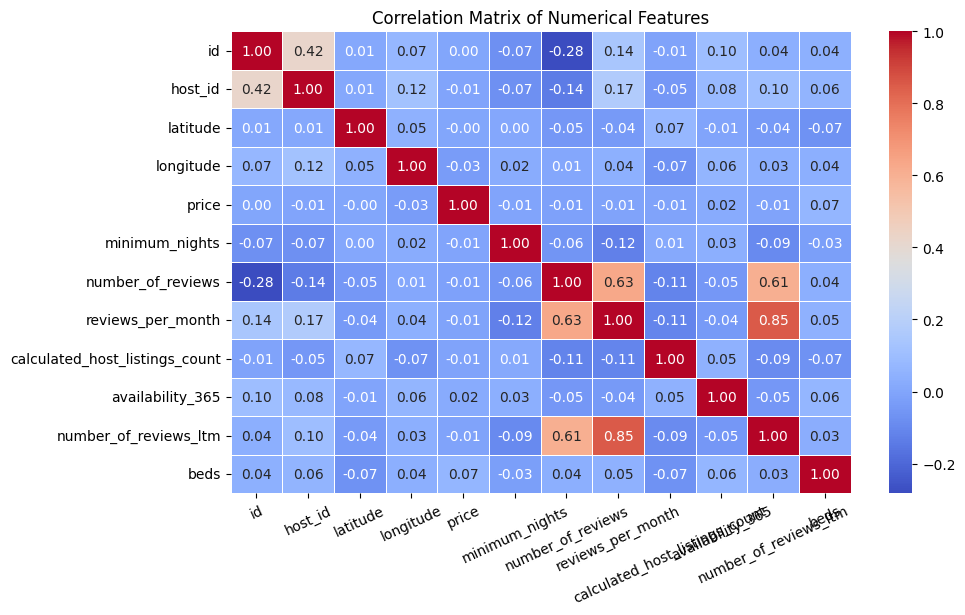

/var/folders/rq/91x5rw3560s1y0v50f_7jmz00000gn/T/ipykernel_48073/1603602975.py:38: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('Bronx', 5)
/var/folders/rq/91x5rw3560s1y0v50f_7jmz00000gn/T/ipykernel_48073/1603602975.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(i, NEIGHBOURHOOD.index(i))
/var/folders/rq/91x5rw3560s1y0v50f_7jmz00000gn/T/ipykernel_48073/1603602975.py:54: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old be

In [33]:
DF = df_cleanup()


In [34]:
print(DF.shape)
print(DF.dtypes)
print(ROOM_TYPE)
print(NEIGHBOURHOOD)
print(DF)

(17963, 13)
id                       int64
host_id                  int64
neighbourhood_group      int64
neighbourhood            int64
latitude               float64
longitude              float64
room_type                int64
price                  float64
number_of_reviews        int64
rating                 float64
bedrooms                 int64
beds                     int64
baths                  float64
dtype: object
['Entire home/apt', 'Private room', 'Hotel room', 'Shared room']
["Hell's Kitchen", 'Chelsea', 'Washington Heights', 'Murray Hill', 'Williamsburg', 'Sunset Park', 'Astoria', 'Financial District', 'Midtown', 'Upper West Side', 'Concourse Village', 'Flushing', 'Greenpoint', 'Cypress Hills', "Prince's Bay", 'Port Richmond', 'East Village', 'Clason Point', 'Bedford-Stuyvesant', 'Gravesend', 'Long Island City', 'Gramercy', 'East Flatbush', 'Kensington', 'St. George', 'South Ozone Park', 'Wakefield', 'Forest Hills', 'Springfield Gardens', 'North Riverdale', 'Belmont', 'C

In [35]:
#chech if there is entries with price > 3000
def check_price(df):
    if df[df['price'] > 3000].empty:
        print("No entries with price > 3000")
    else:
        print("There are entries with price > 3000")
        print(df[df['price'] > 3000])

check_price(DF)

No entries with price > 3000


In [36]:
X = DF.drop('price', axis = 1)
X = X.drop('id', axis = 1)

y = DF[['price']]

Scaler = preprocessing.MinMaxScaler()
X = Scaler.fit_transform(X)
X = pd.DataFrame(X, columns=DF.columns[2:])

print(DF.shape)
print(DF.dtypes)
print(DF)

(17963, 13)
id                       int64
host_id                  int64
neighbourhood_group      int64
neighbourhood            int64
latitude               float64
longitude              float64
room_type                int64
price                  float64
number_of_reviews        int64
rating                 float64
bedrooms                 int64
beds                     int64
baths                  float64
dtype: object
                       id    host_id  neighbourhood_group  neighbourhood  \
1                45277537   51501835                    1              0   
2      971353993633883038  528871354                    1              1   
3                 3857863   19902271                    1              2   
4                40896611   61391963                    1              3   
5                49584983   51501835                    1              0   
...                   ...        ...                  ...            ...   
20750  791754056397616680  429183811   

### Polynomial Regression

In [37]:
# from sklearn.model_selection import kfold
pca = PCA(n_components=8)

poly = PolynomialFeatures(degree=2, include_bias=False)

poly_features = poly.fit_transform(X)
poly_features = pca.fit_transform(poly_features)

# k = 5
# kf = kfold.KFold(n_splits=k, shuffle=True)

X_train,X_test, y_train, y_test = train_test_split(poly_features, y, test_size = 0.2)

reg_model = linear_model.LinearRegression()
reg_model = LinearRegression().fit(X_train, y_train)

print('Intercept: ',reg_model.intercept_)
list(zip(X, reg_model.coef_))

y_pred= reg_model.predict(X_test)  
x_pred= reg_model.predict(X_train)

y_test = pd.DataFrame(y_test)
y_pred = pd.DataFrame(y_pred)

reg_model_diff = pd.DataFrame({'Actual value': y_test.iloc[:, 0], 'Predicted value': y_pred.iloc[:, 0]})
reg_model_diff.dropna(inplace=True)
print ("Model Score: ", reg_model.score(X_test, y_test))
print(metrics.mean_absolute_error(y_test,reg_model.predict(X_test)))
print(reg_model_diff)

Intercept:  [160.99419994]
Model Score:  0.29283697330683267
      Actual value  Predicted value
1            144.0       110.235919
7            130.0       189.503259
12           100.0       169.292447
34            69.0       215.301935
35           188.0        83.867143
...            ...              ...
3562         218.0       138.793499
3570         150.0       142.164327
3575          90.0       145.715240
3578          65.0       144.482929
3591         469.0       242.657721

[557 rows x 2 columns]


### SVM regression

In [38]:
from sklearn import svm

regr = svm.SVR()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

regr.fit(X_train, y_train.values.ravel())

y_pred = regr.predict(X_test)

print('SVM model score: ', regr.score(X_test, y_test))

SVM model score:  0.17095215425833388


In [39]:
#evcaluation metrics
from sklearn import metrics
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R^2 score:', metrics.r2_score(y_test, y_pred))

Mean Squared Error: 16007.73440254773
Mean Absolute Error: 69.01656432446305
Root Mean Squared Error: 126.52167562337976
R^2 score: 0.17095215425833388


Correlation Matrix

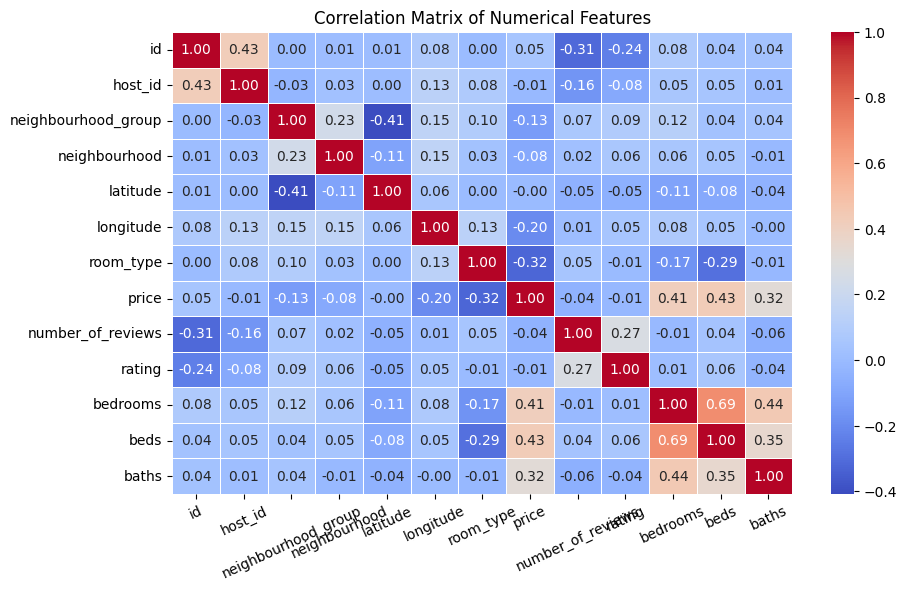

In [40]:
numerical_columns = DF.select_dtypes(include='number')
correlation_matrix = numerical_columns.corr()
# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.xticks(rotation = 25)
plt.show()

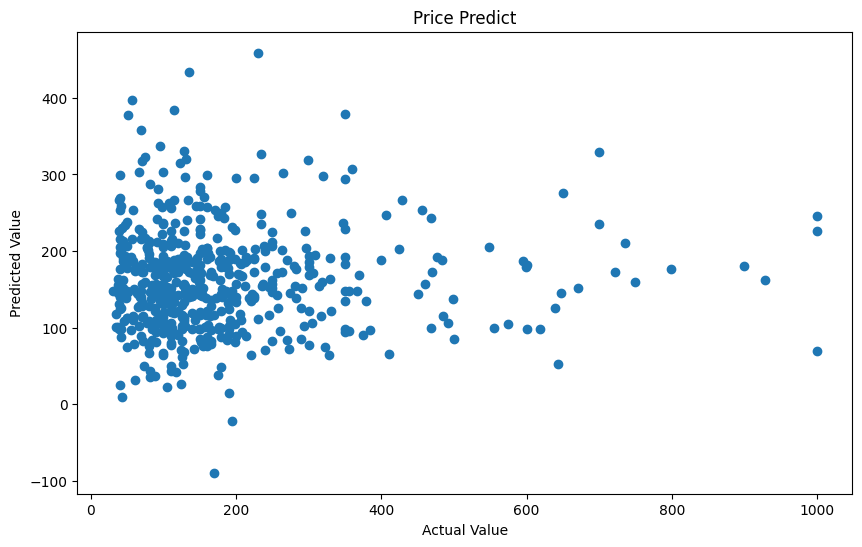

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(reg_model_diff.iloc[:, 0], reg_model_diff.iloc[:, 1])
plt.title("Price Predict")
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.show()

Artificial Neural Network

In [45]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

X = DF.drop('price', axis = 1)
X = X.drop('id', axis = 1)
y = DF[['price']].values.reshape(-1,)

Scaler = preprocessing.MinMaxScaler()
X = Scaler.fit_transform(X)
X = pd.DataFrame(X, columns=DF.columns[2:])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5)
regr = MLPRegressor(max_iter=2000, 
                          hidden_layer_sizes={50,50,25},
                          n_iter_no_change=500,
                          verbose=True,
                          learning_rate='constant',
                          learning_rate_init=.001).fit(X_train, y_train)
print(regr.score(X_test, y_test))

Iteration 1, loss = 21570.54213525
Iteration 2, loss = 20911.60167224
Iteration 3, loss = 18784.17047362
Iteration 4, loss = 14666.55975465
Iteration 5, loss = 10757.45894130
Iteration 6, loss = 9428.22748615
Iteration 7, loss = 9206.06401523
Iteration 8, loss = 9042.15320161
Iteration 9, loss = 8890.09969843
Iteration 10, loss = 8740.51566645
Iteration 11, loss = 8592.55766510
Iteration 12, loss = 8434.62286074
Iteration 13, loss = 8253.57902686
Iteration 14, loss = 8056.99823201
Iteration 15, loss = 7853.33889833
Iteration 16, loss = 7649.77519637
Iteration 17, loss = 7446.94661027
Iteration 18, loss = 7248.60032865
Iteration 19, loss = 7067.19772505
Iteration 20, loss = 6911.57535811
Iteration 21, loss = 6770.14139827
Iteration 22, loss = 6649.54827082
Iteration 23, loss = 6554.76447708
Iteration 24, loss = 6477.35466689
Iteration 25, loss = 6413.34552615
Iteration 26, loss = 6365.24214615
Iteration 27, loss = 6325.28302254
Iteration 28, loss = 6291.57881418
Iteration 29, loss = 626

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [46]:
print(pd.DataFrame(regr.predict(X_test)))
print(pd.DataFrame(y_test))
print(metrics.mean_absolute_error(y_test,regr.predict(X_test)))

               0
0     263.326762
1     177.401117
2     156.005479
3     114.431062
4      69.434646
...          ...
8977   99.595462
8978  210.856945
8979  138.107203
8980  188.416239
8981   84.746306

[8982 rows x 1 columns]
          0
0     120.0
1     135.0
2     175.0
3     225.0
4      52.0
...     ...
8977   70.0
8978  276.0
8979  145.0
8980  174.0
8981  125.0

[8982 rows x 1 columns]
59.8602159088714
